# PreProcessing points coordinate

In [2]:
import numpy as np

x_min, x_max = -0.5, 1.5
z_min, z_max = -1, 1
res = 256

x_values = np.linspace(x_min, x_max, res)
z_values = np.linspace(z_min, z_max, res)
y_values = [0.2, 0.65, 0.8, 0.9, 0.96, 0.99]

write_path = 'system/include/AIP'
with open('system/include/AIP', 'w') as file:
    file.write("pts\n(\n")
    for z in z_values:
        for y in y_values:
            y *= 1.1963
            for x in x_values:
                file.write(f"({x} {y} {z})\n")
    file.write(");")
print(f'Write the surface points in {write_path} file.')

Write the surface points in system/include/AIP file.


# PostProcessing

## Global

### boundaryCloud

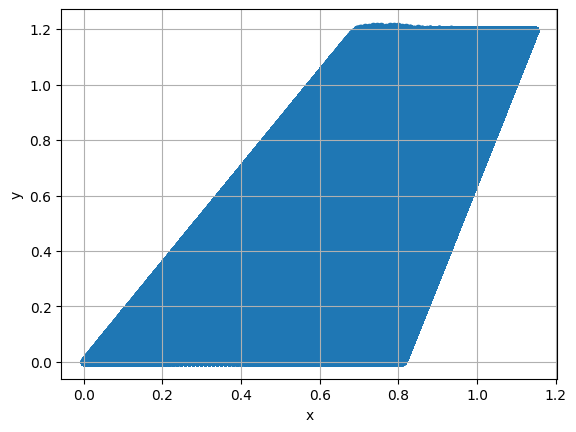

In [106]:
import pandas as pd
file_path = 'postProcessing/boundaryCloud/1200/cloud_p.xy'
cloud_p_content = pd.read_csv(file_path, delimiter='\s+', header=None, names=['x','y','z','p']).round(5)
section_df = cloud_p_content[cloud_p_content['z'] >= 0.]
section_df.plot(kind='scatter',x='x',y='y')
import matplotlib.pyplot as plt
plt.grid()

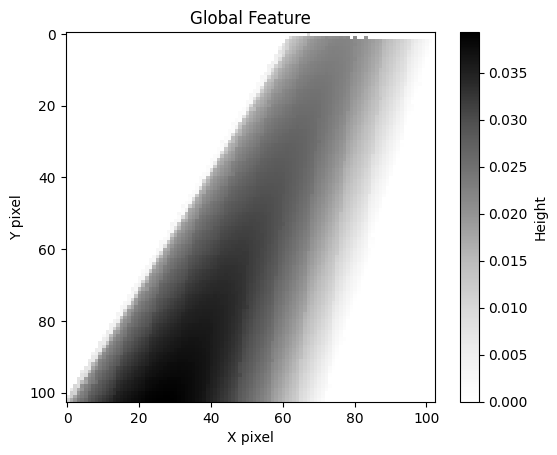

In [172]:
import numpy as np
import pandas as pd
file_path = 'postProcessing/boundaryCloud/1200/cloud_p.xy'
postProcessing_content = pd.read_csv(file_path, delimiter='\s+', skiprows=0, header=None, names=['x','y','z','p'])
upper = postProcessing_content[(postProcessing_content['z'] >= 0.)]
x = upper['x']
y = upper['y']
z = upper['z']
normalized_x = (x - x.min()) / (x.max() - x.min())
normalized_y = y / y.max()
normalized_x.min()
res = round(len(x) ** (1/3))
npOutput = np.zeros((res,res))
npOutput[(normalized_x * (res-1)).astype(int), (normalized_y * (res-1)).astype(int)] = z
field = np.copy(npOutput)
field = np.flipud(field.transpose())

import matplotlib.pyplot as plt
plt.imshow(field, cmap='Greys', interpolation='nearest')
plt.colorbar(label='Height')
plt.title('Global Feature')
plt.xlabel('X pixel')
plt.ylabel('Y pixel')
plt.show()

## InternalProbes

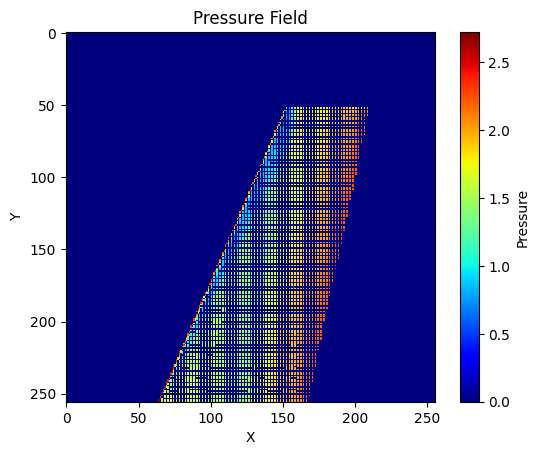

In [10]:
import numpy as np
import pandas as pd
file_path = 'postProcessing/boundaryProbes/1200/points.xy'
postProcessing_content = pd.read_csv(file_path, delimiter='\s+', skiprows=1, header=None, names=['x','y','z','p'])
upper = postProcessing_content[(postProcessing_content['z'] >= 0.)]
x = upper['x']
y = upper['y']
p = upper['p']
pv = 0.5 * 1.151 * 292.67**2
normalized_x = (x + 0.5) / 2
normalized_y = y / 1.5
res = 256
npOutput = np.zeros((res,res))
npOutput[(normalized_x * (res-1)).astype(int), (normalized_y * (res-1)).astype(int)] = p / pv
field = np.copy(npOutput)
field = np.flipud(field.transpose())

import matplotlib.pyplot as plt
plt.imshow(field, cmap='jet', interpolation='nearest')
plt.colorbar(label='Pressure')
plt.title('Pressure Field')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# list(colormaps)

## BoundaryProbes

/tmp/ipykernel_11561/1350245409.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boundary_content['X/L'] = (boundary_content['x'] - lead) / L


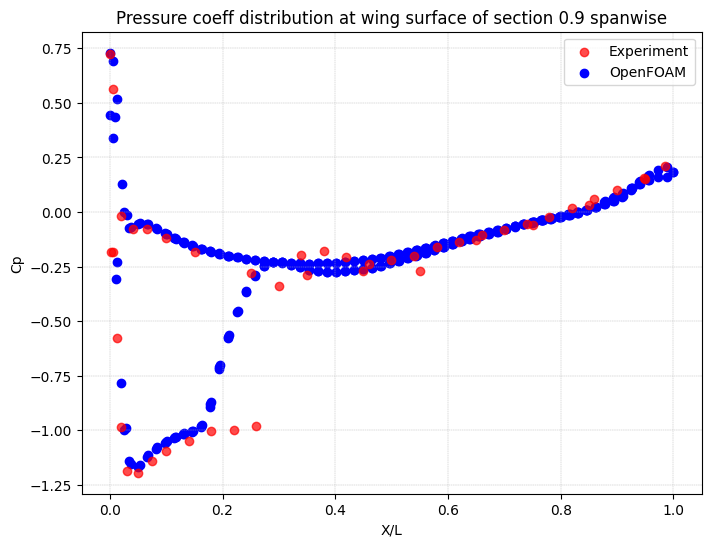

In [3]:
import pandas as pd
import numpy as np
# file_path = 'postProcessing/internalProbes/2000/points.xy'
# boundary_content = pd.read_csv(file_path, delimiter='\s+', skiprows=1, header=None, names=['x','y','z','p','Ux','Uy','Uz']).round(5)
file_path = 'postProcessing/boundaryProbes/1200/points.xy'
boundary_content = pd.read_csv(file_path, delimiter='\s+', skiprows=1, header=None, names=['x','y','z','p']).round(5)
rho = 1.184
v = 292.67
pv = 0.5 * rho * (v**2)
boundary_content['Cp'] = (boundary_content['p']-98858.97) / pv
def normalize(boundary_content):
    L = boundary_content['x'].max() - boundary_content['x'].min()
    lead = boundary_content['x'].min()
    boundary_content['X/L'] = (boundary_content['x'] - lead) / L
    return boundary_content

section = 0.9
y_coord = np.round(1.1963 * section,5)
of_df = boundary_content[(boundary_content['y'] <= y_coord + 1e-2) & (boundary_content['y'] >= y_coord - 1e-2)]
of_df = normalize(of_df)
exp_path = f"exp/exp{int(section * 100)}pc.csv"
exp_df = pd.read_csv(exp_path, delimiter='\s+', header=None, names=['Section','Tap','X/L','Z/L','Cp']).round(5)
# of_df.plot(kind='scatter',x='x',y='z')

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(exp_df['X/L'], exp_df['Cp'], color='red',alpha=0.7, label='Experiment', zorder=2)
plt.scatter(of_df['X/L'], of_df['Cp'], color='blue', label='OpenFOAM')
# plt.scatter(of_upper['X/L'], of_upper['Cp'], color='blue', marker='^', label='OpenFOAM upper')
# plt.scatter(of_lower['X/L'], of_lower['Cp'], color='blue', marker='v', label='OpenFOAM lower')

plt.xlabel('X/L')
plt.ylabel('Cp')
plt.title(f'Pressure coeff distribution at wing surface of section {section} spanwise')
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.legend()
plt.savefig(f"plots/section{int(section*100)}pc")

# Residual plot

In [15]:
import re
log_path = 'log/hisa.log'
with open(log_path,'r') as file:
    log_content = file.read()
GMRES_pattern = r"GMRES iteration: 0\s+Residual:\s+([0-9.]+)"
GMRES_matches = re.findall(GMRES_pattern, log_content)
omega_pattern = r"Solving for omega, Initial residual = ([0-9.eE+-]+)"
omega_matches = re.findall(omega_pattern, log_content)
k_pattern = r"smoothSolver:  Solving for k, Initial residual = ([0-9.eE+-]+)"
k_matches = re.findall(k_pattern, log_content)

if GMRES_matches:
    GMRES_residual = [float(value) for value in GMRES_matches]
else:
    print("No GMRES matches found")

if omega_matches:
    omega_residual = [float(value) for value in omega_matches]
else:
    print("No matches found for Omega Initial residual")

if k_matches:
    k_residual = [float(value) for value in k_matches]
else:
    print("No matches found for K Initial residual")

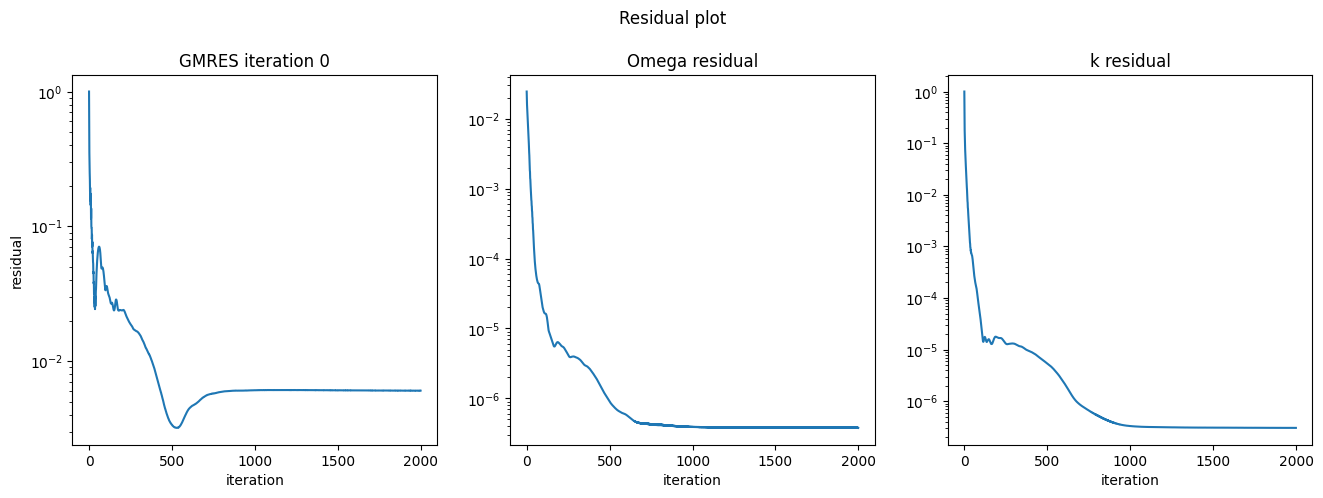

In [16]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,3, figsize=(16,5))
axes[0].semilogy(GMRES_residual)
axes[0].set_title('GMRES iteration 0')
axes[0].set_ylabel('residual')
axes[0].set_xlabel('iteration')
axes[1].semilogy(omega_residual)
axes[1].set_title('Omega residual')
axes[1].set_xlabel('iteration')
axes[2].semilogy(k_residual)
axes[2].set_title('k residual')
axes[2].set_xlabel('iteration')

fig.suptitle('Residual plot')
plt.subplots_adjust(top=0.85)